# Learning Path Recommender System

In [1]:
# importing all the required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# following functions are loaded from surprise module
from surprise import NormalPredictor
from surprise import Reader
from surprise import SVD
from surprise import Dataset, evaluate
from surprise.model_selection import cross_validate
from sklearn.metrics import accuracy_score
%matplotlib inline

### Reading the dataset

Here we will read the logs into DataFrame

## Using Spark to read the large log file
- Here the log files can recide in local or HDFS

In [2]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
sc = SparkContext()

In [3]:
# Initialize the sql context
spark = SQLContext(sc)

**Logs which are in csv format are converted to spark RDD's**

In [4]:
# Read the csv to spark rdd
# Read the files form hdfs "hdfs://ip-172-31-53-48.ec2.internal:8020/data/greatlearning/Team5/logs_lk.csv"
logs_rdd = sc.textFile("10000/logs.csv").map(lambda line: line.split(","))

**Check the structure of rdd**

In [5]:
logs_rdd.take(5)

[['1', 'P1', '2013-02-28 10:13:03'],
 ['1', 'P1M4L1V1', '2013-03-02 04:46:57', '2013-03-02 06:46:57'],
 ['1', 'P1M4L1S1', '2013-03-05 15:19:06', '2013-03-05 15:19:06'],
 ['1', 'P1M4L1A2', '2013-03-16 16:33:05', '2013-03-16 16:33:05'],
 ['1', 'P1M4L1V1', '2013-03-17 02:20:13', '2013-03-17 04:20:13']]

The null entry in the EndTime column are the program start event. Since we will not be using that data for our recommender system, we shall drop those rows.

In [6]:
# Remove the program start event
logs_rdd = logs_rdd.filter(lambda r: len(r) == 4)

In [7]:
# Convert the logs to pandas data frame
logs_df = logs_rdd.toDF(schema=["UserId", "Event", "StartTime", "EndTime"])

### Use of spark
We can use spark data frame for further analysis, but we will be using pandas dataframe for the ease of use.

In [8]:
# Reading the data 
logs_df = pd.read_csv("10000/logs.csv", header=None, \
                      names=["UserId", "Event", "StartTime", "EndTime"],\
                      parse_dates=[2,3]
                )

Lets find out the number of rows/events we got

In [9]:
# Print the number of rows in the data frame
number_of_events = logs_df.shape[0]
print("This Log file has {} rows/events".format(number_of_events))

This Log file has 856042 rows/events


### Insights
- We have 856042 events to work with

Lets check the structure of the DataFrame

In [10]:
# Print the logs_df information
logs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856042 entries, 0 to 856041
Data columns (total 4 columns):
UserId       856042 non-null int64
Event        856042 non-null object
StartTime    856042 non-null datetime64[ns]
EndTime      846042 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 26.1+ MB


Check the data, by calling head function on the dataframe

In [11]:
# Displaying top 10 rows of dataframe
logs_df.head(10)

,UserId,Event,StartTime,EndTime
0,1,P1,2013-02-28 10:13:03,NaT
1,1,P1M4L1V1,2013-03-02 04:46:57,2013-03-02 06:46:57
2,1,P1M4L1S1,2013-03-05 15:19:06,2013-03-05 15:19:06
3,1,P1M4L1A2,2013-03-16 16:33:05,2013-03-16 16:33:05
4,1,P1M4L1V1,2013-03-17 02:20:13,2013-03-17 04:20:13
5,1,P1M4L1Q1,2013-03-23 01:51:01,2013-03-23 02:21:01
6,1,P1M4L1V3,2013-03-26 11:45:59,2013-03-26 13:45:59
7,1,P1M4L2V3,2013-03-31 19:17:52,2013-03-31 21:17:52
8,1,P1M4L2V1,2013-04-04 21:49:17,2013-04-04 23:49:17
9,1,P1M4L2Q1,2013-04-10 12:25:37,2013-04-10 12:55:37


### Column Definition
- UserId      : Unique ID given to a user/student
- Event       : The event name
- StartTime   : Start time of the event
- EndTime     : End time of the event

### Expanding the event acronym 

Following are the meaning of each letter
-    P Program
-    M Module
-    L Lesson
-    A Additional Links
-    Q Quiz
-    V Video
-    S Assignment
-    F Final Assignment

Ex: P1M4L2V2 = Event of Program 1, Module 4, Lesson 2, Video 2

#### More info on the events:

-    Every lesson has 8 events.
-    Quiz and Assignment occur only once
-    Video duration is 2hrs
-    Quiz duration is 30min
-    Additional links and Assignments, start and end time is same
-    Timeframe chosen is 2013-2018


### Data Cleaning

In [12]:
# Count number of null values
logs_df.isnull().sum()

UserId           0
Event            0
StartTime        0
EndTime      10000
dtype: int64

There are 10000 entries in the EndTime column which are Null. Lets check those entries

In [13]:
# Inspect the null values
logs_df[logs_df["EndTime"].isnull() == True]

,UserId,Event,StartTime,EndTime
0,1,P1,2013-02-28 10:13:03,NaT
98,2,P1,2016-03-21 22:59:50,NaT
189,3,P1,2016-09-20 17:41:52,NaT
280,4,P1,2017-11-09 03:43:22,NaT
313,5,P1,2016-12-24 09:06:47,NaT
410,6,P1,2014-12-09 17:33:41,NaT
498,7,P1,2017-12-04 08:10:27,NaT
517,8,P1,2015-05-12 20:26:05,NaT
619,9,P1,2014-10-08 11:09:27,NaT
715,10,P1,2013-06-13 02:50:37,NaT


The null entry in the EndTime column are the program start event. Since we will not be using that data for our recommender system, we shall drop those rows.

In [14]:
# Dropping the rows with null entries
logs_df.dropna(inplace=True)

In [15]:
# Number of rows dropped 
print("Total number of rows dropped: {}".format(number_of_events - logs_df.shape[0]))

Total number of rows dropped: 10000


In [16]:
# Change the datatype of first column to integer
logs_df["UserId"] = logs_df["UserId"].astype(np.int64)

In [17]:
# Check the data types of each column
logs_df.dtypes

UserId                int64
Event                object
StartTime    datetime64[ns]
EndTime      datetime64[ns]
dtype: object

### Filtering only the Quiz events from the entire logs

In [18]:
# Extracting the quiz
quiz_logs_df = logs_df[logs_df.apply(lambda x: "Q" in x['Event'], axis=1)]

In [19]:
# Shape of the data frame
quiz_logs_df.shape

(90903, 4)

Inspect the quiz logs data frame

In [20]:
# Call head on the quiz
quiz_logs_df.head(10)

,UserId,Event,StartTime,EndTime
5,1,P1M4L1Q1,2013-03-23 01:51:01,2013-03-23 02:21:01
9,1,P1M4L2Q1,2013-04-10 12:25:37,2013-04-10 12:55:37
14,1,P1M4L3Q1,2013-05-09 02:37:46,2013-05-09 03:07:46
18,1,P1M3L3Q1,2013-05-30 13:28:58,2013-05-30 13:58:58
26,1,P1M3L2Q1,2013-07-04 05:08:27,2013-07-04 05:38:27
38,1,P1M3L1Q1,2013-08-05 20:44:09,2013-08-05 21:14:09
41,1,P1M1L3Q1,2013-08-28 02:48:06,2013-08-28 03:18:06
49,1,P1M1L2Q1,2013-09-29 16:10:15,2013-09-29 16:40:15
56,1,P1M1L1Q1,2013-10-26 18:14:14,2013-10-26 18:44:14
68,1,P1M2L1Q1,2013-11-28 15:47:42,2013-11-28 16:17:42


### Creating the quiz matrix

In [21]:
# All the quiz names
quiz_names = quiz_logs_df["Event"].unique()

In [22]:
# Print all the quiz names
print("All the quiz names:")
print(*quiz_names, sep="\n")

All the quiz names:
P1M4L1Q1
P1M4L2Q1
P1M4L3Q1
P1M3L3Q1
P1M3L2Q1
P1M3L1Q1
P1M1L3Q1
P1M1L2Q1
P1M1L1Q1
P1M2L1Q1
P1M2L2Q1
P1M2L3Q1


In [23]:
# Creating a data frame to hold the quiz matrix
quiz_matrix = pd.DataFrame(columns=np.append(np.array(["UserId"]), quiz_names))

In [24]:
# Check the head of the matrix
quiz_matrix.head()

,UserId,P1M4L1Q1,P1M4L2Q1,P1M4L3Q1,P1M3L3Q1,P1M3L2Q1,P1M3L1Q1,P1M1L3Q1,P1M1L2Q1,P1M1L1Q1,P1M2L1Q1,P1M2L2Q1,P1M2L3Q1


Fill the quiz_matrix with 1 or 0 depending on whether the user has taken the quiz or not.

In [25]:
# group the users by id
grouped = quiz_logs_df.groupby(by="UserId")
# Iterate each user and add them to the matrix
for userid, group in grouped:
    temDict = {"UserId": userid}
    for row in group.iterrows():
        temDict[row[1]["Event"]] = 1
    quiz_matrix = quiz_matrix.append(temDict, ignore_index=True)
# Fill all the null values with 0
quiz_matrix.fillna(0, inplace=True)

In [26]:
# check the matrix
quiz_matrix.head(10)

,UserId,P1M4L1Q1,P1M4L2Q1,P1M4L3Q1,P1M3L3Q1,P1M3L2Q1,P1M3L1Q1,P1M1L3Q1,P1M1L2Q1,P1M1L1Q1,P1M2L1Q1,P1M2L2Q1,P1M2L3Q1
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,3.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
3,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
4,5.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
5,6.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
6,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
7,8.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
8,9.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
9,10.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


In [27]:
# Saving a copy of this matrix for use after the prediction
# Making a deep copy
quiz_matrix_pred = quiz_matrix.copy()

### Fill the matrix with actual scores
Above quiz_matrix tells us if the student has taken the quiz or not. Now if the user has taken the quiz, we will fill that cell with his actual scores

In [44]:
# Read the quiz_scores
quiz_scores_df = pd.read_csv("10000/quiz.csv", sep=',', header=None, \
                    names=["UserId", "Event", "Score", "Student Type"])

In [45]:
# Display few rows of quiz scores
quiz_scores_df.head()

,UserId,Event,Score,Student Type
0,1,P1M4L1Q1TS,4,P
1,1,P1M4L2Q1TS,6,P
2,1,P1M4L3Q1TS,4,P
3,1,P1M3L3Q1TS,3,P
4,1,P1M3L2Q1TS,7,P


This data frame has 4 columns:
- User ID
- Event
- Score
- Student Type

Student Type:
- T - Brilliant
- A - Average
- P - Below Average


### Insert the scores into quiz_matrix
We will insert the scores into the quiz_matrix. The event column need some cleaning, because with the event name, it also a subscript "TS". We will remove it here.

In [46]:
# Read the scores and insert it into quiz_matrix
for index, row in quiz_scores_df.iterrows():
    quiz_matrix.loc[quiz_matrix["UserId"] == row["UserId"], row["Event"][:-2]] = row["Score"]

In [47]:
# display the quiz_matrix
quiz_matrix.head(10)

,UserId,P1M4L1Q1,P1M4L2Q1,P1M4L3Q1,P1M3L3Q1,P1M3L2Q1,P1M3L1Q1,P1M1L3Q1,P1M1L2Q1,P1M1L1Q1,P1M2L1Q1,P1M2L2Q1,P1M2L3Q1
0,1.0,4.0,6.0,4.0,3.0,7.0,8.0,8.0,8.0,6.0,4.0,8.0,9.0
1,2.0,6.0,8.0,9.0,9.0,9.0,8.0,10.0,10.0,10.0,9.0,10.0,9.0
2,3.0,6.0,8.0,6.0,8.0,8.0,9.0,10.0,9.0,8.0,8.0,9.0,8.0
3,4.0,6.0,6.0,7.0,7.0,6.0,6.0,9.0,10.0,10.0,9.0,9.0,9.0
4,5.0,1.0,2.0,9.0,7.0,7.0,7.0,8.0,7.0,10.0,8.0,10.0,8.0
5,6.0,5.0,1.0,1.0,6.0,6.0,6.0,8.0,7.0,6.0,0.0,7.0,7.0
6,7.0,4.0,5.0,3.0,7.0,7.0,0.0,9.0,8.0,0.0,9.0,6.0,7.0
7,8.0,6.0,7.0,7.0,6.0,8.0,6.0,10.0,9.0,10.0,8.0,8.0,5.0
8,9.0,4.0,4.0,2.0,7.0,9.0,7.0,8.0,7.0,10.0,6.0,7.0,7.0
9,10.0,4.0,4.0,6.0,6.0,5.0,6.0,7.0,8.0,7.0,5.0,7.0,8.0


## Visualization
Lets plot some graph to check the distribution of scores in our matrix

### Histograms of all the quiz scores

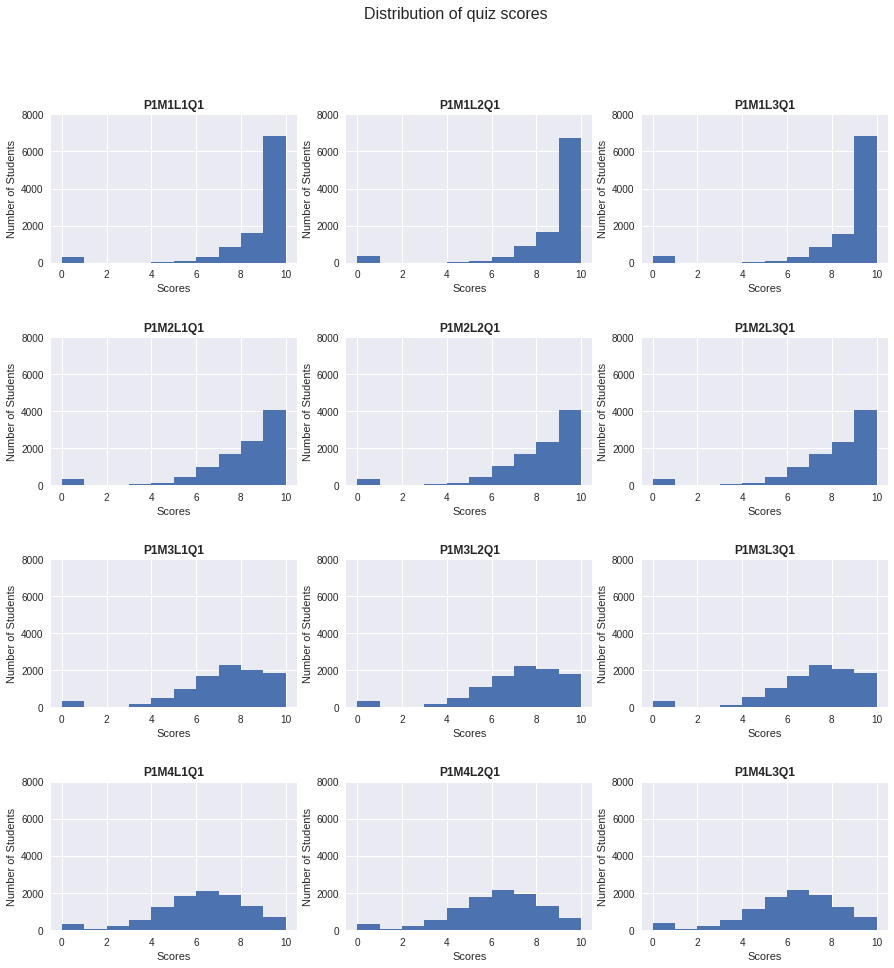

In [50]:
# Plot the histogram for all the names
# Initialize the plot variables
fig, axes = plt.subplots(4, 3, figsize=(15,15))
fig.suptitle("Distribution of quiz scores", fontsize=16)
# fig.subplots_adjust(bottom=0, top=1)
plt.subplots_adjust(hspace=0.5)
row = 0
for index, name in enumerate(sorted(quiz_names)):
    if index != 0  and index % 3 == 0:
        row += 1
    col = index % 3
    axes[row][col].hist(x = name, data=quiz_matrix)
    axes[row][col].set_xlabel('Scores')
    axes[row][col].set_ylabel('Number of Students')
    axes[row][col].set_ylim([0, 8000])
    axes[row][col].set_title(name, weight="bold")
plt.show()

### Insights from the graph
- We can clearly see that as we move from module M1 to M4 the quiz difficulty is increasing.
- Module 1 has many students scoring 10, but that decreases as we move down

### Plotting the scores of quiz 1 for all the 4 modules

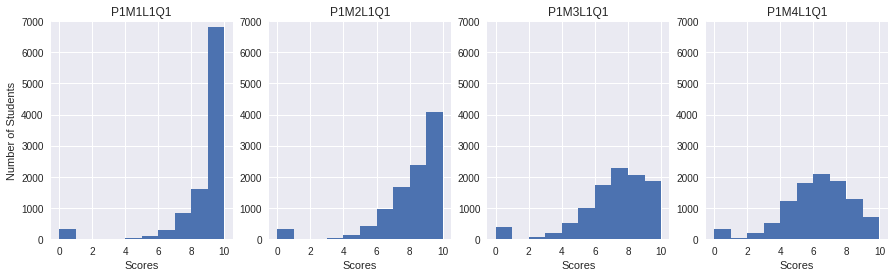

In [52]:
# Initialize the plot variables
fig, axes = plt.subplots(1, 4, figsize=(15, 4))

axes[0].hist(x = "P1M1L1Q1",data=quiz_matrix)
axes[0].set_xlabel('Scores')
axes[0].set_ylabel('Number of Students')
axes[0].set_ylim([0, 7000])
axes[0].set_title("P1M1L1Q1")

axes[1].hist(x = "P1M2L1Q1",data=quiz_matrix)
axes[1].set_xlabel('Scores')
axes[1].set_ylim([0, 7000])
axes[1].set_title("P1M2L1Q1")

axes[2].hist(x = "P1M3L1Q1",data=quiz_matrix)
axes[2].set_xlabel('Scores')
axes[2].set_ylim([0, 7000])
axes[2].set_title("P1M3L1Q1")

axes[3].hist(x = "P1M4L1Q1",data=quiz_matrix)
axes[3].set_xlabel('Scores')
axes[3].set_ylim([0, 7000])
axes[3].set_title("P1M4L1Q1")

plt.show()

### Insights from the graph
- We can clearly see that as we move from module M1 to M4 the quiz difficulty is increasing.
- Module 1 has many students scoring 10, but that decreases as we move toward right

### Box plot for quiz matrix

/home/dalonlobo/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


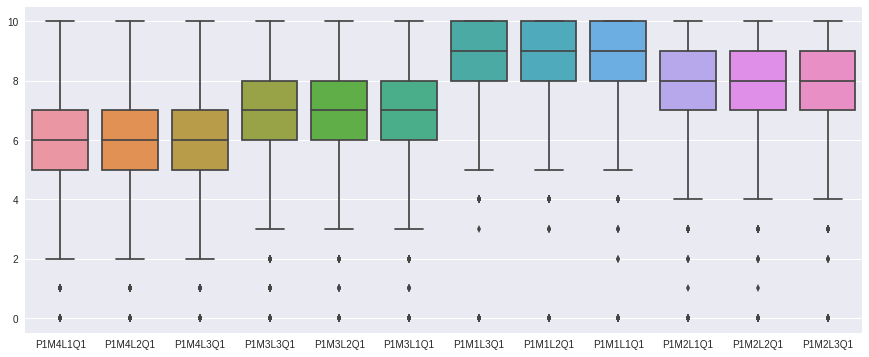

In [53]:
# Box plot using sns
plt.figure(figsize=(15,6))
sns.boxplot(quiz_matrix.iloc[:,1:])

### Insights
- The distribution of Module 4 is centered around score 6 i.e students takig quiz of module 4, most of them are scoring 6 out of 10
- The distribution of Module 3 is centered around score 7
- The distribution of Module 2 is centered around score 8
- The distribution of Module 1 is centered around score 9

## Summary of the quiz_matrix

In [54]:
# Summary of the matrix
quiz_matrix.describe()

,UserId,P1M4L1Q1,P1M4L2Q1,P1M4L3Q1,P1M3L3Q1,P1M3L2Q1,P1M3L1Q1,P1M1L3Q1,P1M1L2Q1,P1M1L1Q1,P1M2L1Q1,P1M2L2Q1,P1M2L3Q1
count,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000
mean,5001.030021,5.798759,5.808566,5.791154,6.763134,6.720004,6.737516,8.698489,8.680977,8.714000,7.756930,7.727509,7.726208
std,2887.539729,2.011633,1.985808,2.029583,2.045918,2.073909,2.089484,2.023198,2.016320,1.987315,2.002415,2.055305,2.065116
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2500.000000,5.000000,5.000000,5.000000,6.000000,6.000000,6.000000,8.000000,8.000000,8.000000,7.000000,7.000000,7.000000
50%,5002.000000,6.000000,6.000000,6.000000,7.000000,7.000000,7.000000,9.000000,9.000000,9.000000,8.000000,8.000000,8.000000
75%,7502.000000,7.000000,7.000000,7.000000,8.000000,8.000000,8.000000,10.000000,10.000000,10.000000,9.000000,9.000000,9.000000
max,10000.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


## Distribution of students not taken the quiz

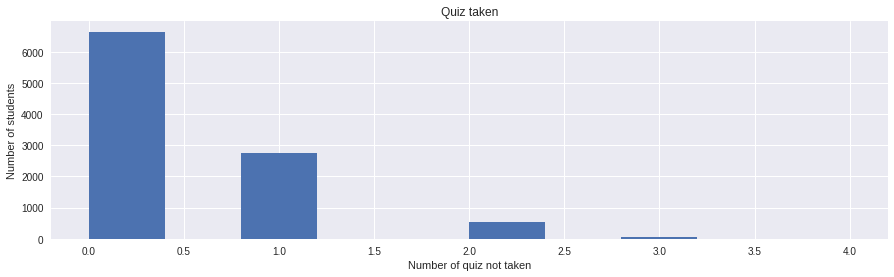

In [55]:
plt.figure(figsize=(15,4))
plt.title("Quiz taken")
plt.xlabel("Number of quiz not taken")
plt.ylabel("Number of students")
# Filter only the 0
(quiz_matrix.iloc[:,1:] == 0).sum(axis=1).hist()
plt.show()

### Insights
- Around 7000 students have taken the quiz
- 3000 students have not taken 1 quiz
- Very few students have not taken 3 or more quizes

### Distribution by quiz id, of students who have not taken the quiz 

In [56]:
# Students not taken quiz
(quiz_matrix.iloc[:,1:] == 0).sum(axis=0)

P1M4L1Q1    315
P1M4L2Q1    299
P1M4L3Q1    347
P1M3L3Q1    334
P1M3L2Q1    363
P1M3L1Q1    371
P1M1L3Q1    334
P1M1L2Q1    333
P1M1L1Q1    319
P1M2L1Q1    306
P1M2L2Q1    336
P1M2L3Q1    342
dtype: int64

In [57]:
# Total students not taken quiz
quiz_not_taken = (quiz_matrix.iloc[:,1:] == 0).sum(axis=1)
total_students_not_taken_quiz = quiz_not_taken[quiz_not_taken > 0].count()
print("Students not taken one or more quiz {} out of {} students".format(total_students_not_taken_quiz, quiz_matrix.shape[0]))

Students not taken one or more quiz 3345 out of 9993 students


### Insights
- Out of 3918 students, 391 students have not taken one or more quizes

# Using Surprise package for Matrix factorisation

Surprise is an easy-to-use Python scikit for recommender systems.

Documentation [link](http://surprise.readthedocs.io/en/stable/getting_started.html#getting-started)

### Import all the required functions from surprise package

In [58]:
from surprise import NormalPredictor
from surprise import Reader
from surprise import SVD
from surprise import Dataset, evaluate
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV


### Read the quiz scores from the quiz logs

In [59]:
# Read the quiz_scores
quiz_df = pd.read_csv("quiz_1000.csv", sep=',', header=None, \
                    names=["UserId", "Event", "Score", "Student Type"])

In [60]:
quiz_df.head()

,UserId,Event,Score,Student Type
0,1,P1M4L1Q1TS,5,T
1,1,P1M4L3Q1TS,6,T
2,1,P1M1L1Q1TS,10,T
3,1,P1M1L3Q1TS,10,T
4,1,P1M1L2Q1TS,10,T


#### The Event id have "TS" in them, lets remove it and also drop the Student Type column

In [61]:
# Drop the last column
quiz_df.drop("Student Type", axis=1, inplace=True)

In [62]:
quiz_df.head(2)

,UserId,Event,Score
0,1,P1M4L1Q1TS,5
1,1,P1M4L3Q1TS,6


In [63]:
# Remove the TS
quiz_df["Event"] = quiz_df["Event"].apply(lambda r: r[:-2])

###  Format the data for surprise

In [64]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 10))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(quiz_df[['UserId', 'Event', 'Score']], reader)

In [65]:
# Check the data
data.df.head()

,UserId,Event,Score
0,1,P1M4L1Q1,5
1,1,P1M4L3Q1,6
2,1,P1M1L1Q1,10
3,1,P1M1L3Q1,10
4,1,P1M1L2Q1,10


### Using grid search to find the best hyper parameters for the model
Exhaustive search over specified parameter values for an estimator.


In [88]:
# Parameters for the model
param_grid = {'n_epochs': np.arange(50,150,50), 
              'n_factors': np.arange(60, 80, 5)}
# Performing the grid search
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
# Fit the data to the best parameter
gs.fit(data)

Find the best "RMSE" scores and the values

In [89]:
# best RMSE score
print("Best RMSE score")
print(gs.best_score['rmse'], end="\n\n")

# combination of parameters that gave the best RMSE score
print("Parameter for this best rmse score")
print(gs.best_params['rmse'])

Best RMSE score
1.40602845139

Parameter for this best rmse score
{'n_epochs': 100, 'n_factors': 65}


### Build the model based on the best parameters

In [90]:
# Algorithm to be used
algo = SVD(n_epochs=100, n_factors=65)
# Retrieve the trainset.
trainset = data.build_full_trainset()
algo.fit(trainset)

In [99]:
# Make some predictions
for i, row in enumerate(quiz_matrix.iterrows()):
    if i == 2: break
    user_id = row[1]["UserId"]
    for quiz_id, val in row[1].iteritems():
        if quiz_id == "UserId": continue
        print("UserId {}: Quiz {}: \nActual = {}\nPredicted = {}".format(user_id, quiz_id,\
                                                                     val, \
                                                                     round(algo.predict(user_id, quiz_id).est)))
        print("----------------------------")

UserId 1.0: Quiz P1M4L1Q1: 
Actual = 4.0
Predicted = 5.0
----------------------------
UserId 1.0: Quiz P1M4L2Q1: 
Actual = 6.0
Predicted = 7.0
----------------------------
UserId 1.0: Quiz P1M4L3Q1: 
Actual = 4.0
Predicted = 6.0
----------------------------
UserId 1.0: Quiz P1M3L3Q1: 
Actual = 3.0
Predicted = 8.0
----------------------------
UserId 1.0: Quiz P1M3L2Q1: 
Actual = 7.0
Predicted = 9.0
----------------------------
UserId 1.0: Quiz P1M3L1Q1: 
Actual = 8.0
Predicted = 8.0
----------------------------
UserId 1.0: Quiz P1M1L3Q1: 
Actual = 8.0
Predicted = 10.0
----------------------------
UserId 1.0: Quiz P1M1L2Q1: 
Actual = 8.0
Predicted = 10.0
----------------------------
UserId 1.0: Quiz P1M1L1Q1: 
Actual = 6.0
Predicted = 10.0
----------------------------
UserId 1.0: Quiz P1M2L1Q1: 
Actual = 4.0
Predicted = 9.0
----------------------------
UserId 1.0: Quiz P1M2L2Q1: 
Actual = 8.0
Predicted = 9.0
----------------------------
UserId 1.0: Quiz P1M2L3Q1: 
Actual = 9.0
Predicted 

### Lets fill this matrix with the predicted scores

In [92]:
# Prediction matrix
quiz_matrix_pred.head()

,UserId,P1M4L1Q1,P1M4L2Q1,P1M4L3Q1,P1M3L3Q1,P1M3L2Q1,P1M3L1Q1,P1M1L3Q1,P1M1L2Q1,P1M1L1Q1,P1M2L1Q1,P1M2L2Q1,P1M2L3Q1
0,1.0,5.0,7.0,6.0,8.0,9.0,8.0,10.0,10.0,10.0,9.0,9.0,9.0
1,2.0,4.0,8.0,7.0,6.0,8.0,9.0,10.0,10.0,10.0,9.0,8.0,10.0
2,3.0,6.0,5.0,6.0,9.0,7.0,9.0,10.0,10.0,10.0,7.0,9.0,10.0
3,4.0,5.0,7.0,8.0,8.0,8.0,7.0,9.0,10.0,10.0,9.0,8.0,10.0
4,5.0,6.0,4.0,4.0,6.0,7.0,6.0,8.0,7.0,10.0,8.0,10.0,8.0


Predicting the scores below

In [93]:
for index, row in quiz_matrix_pred.iterrows():
    user_id = row["UserId"]
    for quiz_name,val in row.iteritems():
        if quiz_name != "UserId":
            quiz_matrix_pred.loc[quiz_matrix_pred["UserId"] == user_id, quiz_name] =\
                round(algo.predict(user_id, quiz_name).est)

In [94]:
# Display the head
quiz_matrix_pred.head()

,UserId,P1M4L1Q1,P1M4L2Q1,P1M4L3Q1,P1M3L3Q1,P1M3L2Q1,P1M3L1Q1,P1M1L3Q1,P1M1L2Q1,P1M1L1Q1,P1M2L1Q1,P1M2L2Q1,P1M2L3Q1
0,1.0,5.0,7.0,6.0,8.0,9.0,8.0,10.0,10.0,10.0,9.0,9.0,9.0
1,2.0,4.0,8.0,7.0,6.0,8.0,9.0,10.0,10.0,10.0,9.0,8.0,10.0
2,3.0,6.0,5.0,6.0,9.0,8.0,9.0,9.0,10.0,10.0,7.0,9.0,10.0
3,4.0,5.0,7.0,8.0,8.0,8.0,7.0,10.0,10.0,10.0,9.0,8.0,10.0
4,5.0,6.0,4.0,4.0,6.0,6.0,6.0,8.0,7.0,10.0,8.0,10.0,8.0


In [95]:
# Total students not taken quiz
quiz_not_taken = (quiz_matrix_pred.iloc[:,1:] == 0).sum(axis=1)
total_students_not_taken_quiz = quiz_not_taken[quiz_not_taken > 0].count()
print("Students not taken one or more quiz {} out of {} students".format(total_students_not_taken_quiz, quiz_matrix.shape[0]))

Students not taken one or more quiz 0 out of 9993 students


### Insights
- You can see that all the cells of the matrix are filled.

## Distribution of the predicted quiz scores

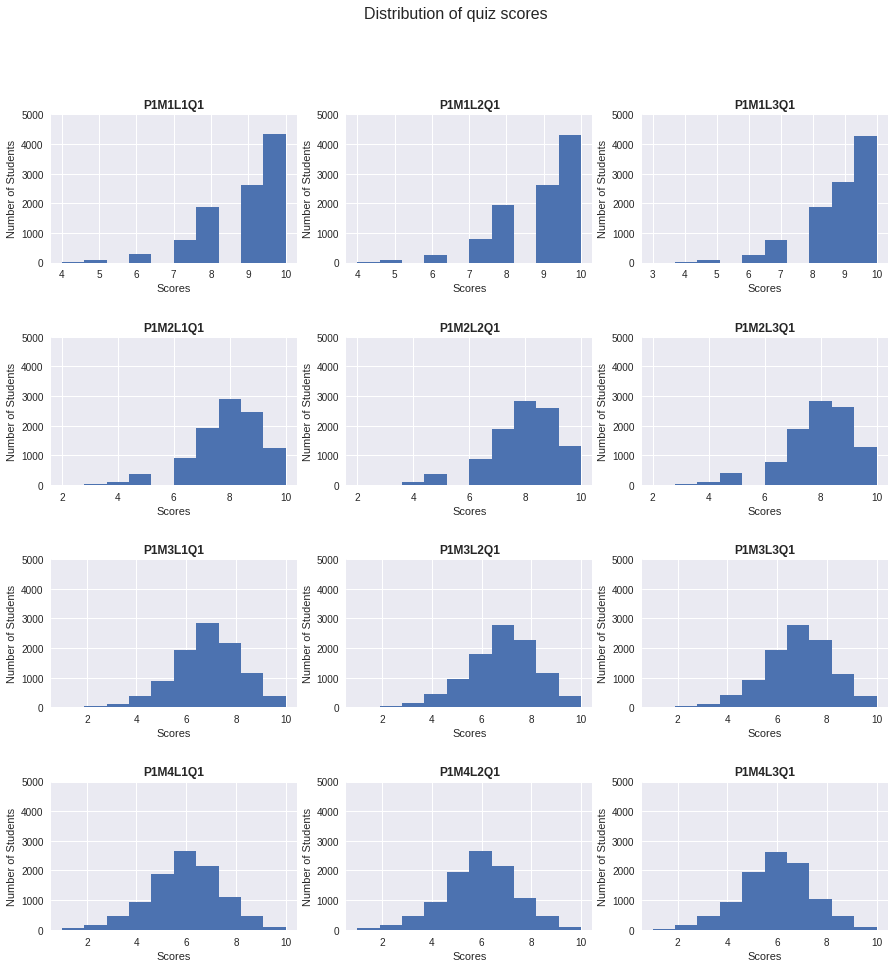

In [96]:
# Plot the histogram for all the names
# Initialize the plot variables
fig, axes = plt.subplots(4, 3, figsize=(15,15))
fig.suptitle("Distribution of quiz scores", fontsize=16)
# fig.subplots_adjust(bottom=0, top=1)
plt.subplots_adjust(hspace=0.5)
row = 0
for index, name in enumerate(sorted(quiz_names)):
    if index != 0  and index % 3 == 0:
        row += 1
    col = index % 3
    axes[row][col].hist(x = name, data=quiz_matrix_pred)
    axes[row][col].set_xlabel('Scores')
    axes[row][col].set_ylabel('Number of Students')
    axes[row][col].set_ylim([0, 5000])
    axes[row][col].set_title(name, weight="bold")
plt.show()

# Appendix

## Explaining the Matrix factorisation

Following is the internal workings of the code

In [97]:
class MF():
    
    def __init__(self, R, K, alpha, beta, iterations):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.
        
        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """
        
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1.0/self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1.0/self.K, size=(self.num_items, self.K))
         
        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])        
        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
              for j in range(self.num_items)
                  if self.R[i, j] > 0]
        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 2 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))
        
        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
#         print()
#         print("SSE = ")
#         print(np.sqrt(error))
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)
            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])
            # Update user and item latent feature matrices
            self.P[i, :] += (self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:]))
            self.Q[j, :] += (self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:]))

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
#         print(prediction , i, j)
        return prediction
    
    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return mf.b + mf.b_u[:,np.newaxis] + mf.b_i[np.newaxis:,] + mf.P.dot(mf.Q.T)

### Using a small sample data set of 27 users

In [98]:
# Read the data
sample_df  = pd.read_csv("sample_27_student.csv")
sample_df.shape

(27, 17)

In [81]:
sample_df.head(27)

,Basic_Stats_Coverage_score,Inferential_Stats_Coverage_score,Statistical_Techniques_Coverage_score,Lin_Reg_Q _Coverage_score,Log_Reg_Coverage_score,DT_Coverage _score,NB_Coverage_score,SVM__Coverage_score,KM_Clustering_Coveragee_score,Basic_Stats_score,Inferential_Stats_score,Linear_Reg_score,Logistic_Reg_score,DT_score,NB_score,SVM_score,KM_Clustering_score
0,10,7,7,7,6,5,10,10,10,8,4,9,9,6,6,8,9
1,7,8,6,8,5,5,5,7,7,6,5,2,2,3,4,4,3
2,0,4,0,0,5,4,6,0,0,5,3,4,4,4,6,5,4
3,4,4,7,5,5,6,6,4,4,8,0,3,3,6,5,4,3
4,6,6,5,5,5,5,5,6,6,0,0,0,0,0,0,0,0
5,4,7,4,5,5,5,7,4,4,0,0,0,0,0,0,6,4
6,0,5,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0
7,0,2,0,0,0,0,7,0,0,6,0,3,3,5,5,3,4
8,0,5,0,0,6,4,7,0,0,0,0,0,0,0,0,0,0
9,6,4,6,6,5,5,4,6,6,6,4,5,3,5,7,5,3


In [82]:
# Convert the datatype for manipulation
R = np.array(sample_df , dtype='long')

### Train the algorithm

In [83]:
mf = MF(R, K=7, alpha=0.1, beta=0.1, iterations=24)
training_process = mf.train()

Iteration: 2 ; error = 15.3194
Iteration: 4 ; error = 10.7467
Iteration: 6 ; error = 9.2281
Iteration: 8 ; error = 8.0901
Iteration: 10 ; error = 7.8568
Iteration: 12 ; error = 7.5943
Iteration: 14 ; error = 7.4635
Iteration: 16 ; error = 7.2608
Iteration: 18 ; error = 7.2788
Iteration: 20 ; error = 7.2967
Iteration: 22 ; error = 7.2015
Iteration: 24 ; error = 7.0893


### The reconstructed quiz matrix

In [84]:
print()
print("P x Q:")
print(mf.full_matrix())


P x Q:
[[ 9.65055164  7.07198381  6.86934221  6.70466998  6.2915669   5.08201054
   9.91421594  9.63272187  9.74960376  8.00211774  4.26052827  8.25080358
   8.5756918   5.97523042  6.14234572  8.06440386  9.09123416]
 [ 7.0323851   7.40435098  6.16149568  7.34605448  5.19567485  4.9751424
   5.1628173   6.93058924  6.96255936  5.9909993   4.85789869  2.60932366
   2.3704404   3.53958372  4.03595694  4.17602425  3.48417697]
 [ 5.65979946  4.02629001  4.93217983  5.02685274  4.7656201   4.39749089
   5.78463549  5.65654342  5.71961636  5.3245526   3.09894889  4.72294776
   3.86631272  4.5194527   5.41510161  4.88564197  4.27928505]
 [ 4.01842208  4.19515873  6.72876251  5.08104032  5.53922008  5.55544624
   5.62649751  3.98933571  3.99625649  7.24436498  3.50878959  2.77964205
   3.11379121  5.18244037  5.71376874  4.0420446   3.20829857]
 [ 5.99149865  5.95848874  5.0040715   5.22715858  5.2335782   4.94339596
   5.25530723  5.92931171  5.98688753  6.18521493  4.15207032  4.31752395
 

### Visualize how the Mean Squared Error reduces in each Iteration during the training 

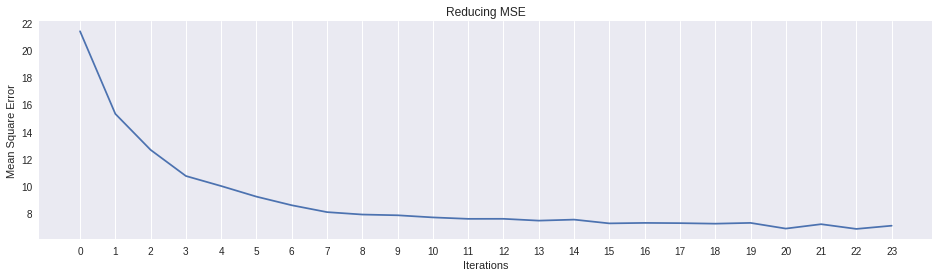

In [85]:
x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.title("Reducing MSE")
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.grid(axis="y")